In [120]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
import os
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, Model
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")


In [122]:
def get_selected_features3(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    lasso = Lasso(alpha=0.01) 
    lasso.fit(X_scaled, y)

    selected_features = np.where(lasso.coef_ != 0)[0]
    X_selected = X[:, selected_features]
    
    scaler = StandardScaler()
    X_selected = scaler.fit_transform(X_selected)
    print(f"Number of selected features: {len(selected_features)}")
    return X_selected


In [125]:
# Function to calculate reconstruction errors
def compute_reconstruction_errors(model, data):
    reconstructions = model.predict(data)
    reconstruction_errors = np.mean(np.square(reconstructions - data), axis=1)
    return reconstruction_errors



In [127]:

#Label noise injection
def inject_label_noise(y, noise_rate=0.05):
    y_noisy = y.copy()
    anomaly_idx = np.where(y_noisy == 1)[0]
    n_anom = len(anomaly_idx)
    n_flip = int(noise_rate * n_anom)
    if n_flip == 0:
        return y_noisy

    flip_idx = np.random.choice(anomaly_idx, size=n_flip, replace=False)
    y_noisy[flip_idx] = 0
    return y_noisy


In [128]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    cm = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = 'N/A' if pred_proba is None else roc_auc_score(y_test, pred_proba)
    
    return accuracy, precision, recall, f1, roc_auc, cm

def calculate_mse(model, data):
  reconstructions = model(data)
  loss = np.mean(np.square(reconstructions - data), axis=1)
  return loss

def predict2(model, data, threshold):
  reconstructions = model(data)
  loss = np.mean(np.square(reconstructions - data), axis=1)
  return np.where(loss > threshold, 1, 0)

# Define data files
mat_file_list = ['arrhythmia.mat',
                 'glass.mat',
                 'cardio.mat',
                 'ionosphere.mat',
                 'letter.mat',
                 'lympho.mat',
                 'mnist.mat',
                 'musk.mat',
                 'optdigits.mat',
                 'pendigits.mat',
                 'pima.mat',
                 'satellite.mat',
                 'satimage-2.mat',
                 'vowels.mat',
                 'wbc.mat',
                 'shuttle.mat']
fs_methods = [get_selected_features3]
kl_weight = 0.1
for fs_method in fs_methods: 
    print("\n\n",fs_method.__name__, " method:")
    # List of metrics to track
    metrics_list = {
        'Dataset': [],
        'Run': [],
        'Noise': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1-score': [],
        'ROC AUC': [],
    }
    for dataset in mat_file_list:
        print(f"Processing dataset: {dataset}")
        
        # Load and prepare data
        mat = loadmat(os.path.join('data', dataset))
        X = mat['X']
        y = mat['y'].ravel()
        
        outliers_fraction = np.count_nonzero(y) / len(y)
        outliers_percentage = round(outliers_fraction * 100, ndigits=2)
        print(f"outliers_percentage: {outliers_percentage} %")
        scaled_features = fs_method(X, y)

        number_of_runs = 10
        for run in range(number_of_runs):
            print(f"Run {run + 1}/{number_of_runs} for {dataset}")
            label_noises=[0.0, 0.05, 0.1]
            for noise in label_noises:
                print(f"  >> Training with label noise (ρ) = {noise}")
                
                # Split data into training and test sets
                y_noisy = inject_label_noise(y, noise)
                X_train, X_test, y_train, y_test = train_test_split(scaled_features, y_noisy, test_size=0.4, random_state=run)
                #X_train, X_test, y_train, y_test = train_test_split(scaled_features, y, test_size=0.4, random_state=run)

                # Normalize the data
                scaler = MinMaxScaler()
                train_data = scaler.fit_transform(X_train)
                test_data = scaler.transform(X_test)
                train_labels = y_train.astype(int)
                test_labels = y_test.astype(int)

                print(f"Normal data shape: {X.shape}")
                print("train: ", X_train.shape)
                print("test: ", X_test.shape)

                # Filter normal and anomalous data based on labels
                normal_train_data = train_data[y_train == 0]
                normal_labels = y_train[y_train == 0]
                anomalous_train_data = train_data[y_train == 1]
                normal_test_data = test_data[y_test == 0]
                anomalous_test_data = test_data[y_test == 1]
                input_dim = X_train.shape[1]
                
                # Sampling layer for the VAE
                class Sampling(layers.Layer):
                    def call(self, inputs):
                        z_mean, z_log_var = inputs
                        batch = tf.shape(z_mean)[0]
                        dim = tf.shape(z_mean)[1]
                        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
                        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

                # True Hybrid Autoencoder-VAE Model
                class AVE(Model):
                    def __init__(self, input_dim, ae_latent_dim, vae_latent_dim, kl_weight, fusion_mode='concat', alpha=0.5):
                        super(AVE, self).__init__()
                        self.kl_weight = kl_weight
                        self.fusion_mode = fusion_mode
                        self.alpha = alpha
                        # Autoencoder Encoder Branch
                        self.ae_encoder = tf.keras.Sequential([
                            layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                            layers.BatchNormalization(),
                            layers.Dropout(0.2),
                            layers.Dense(ae_latent_dim)
                        ])
                        
                        # VAE Encoder Branch
                        self.vae_encoder = tf.keras.Sequential([
                            layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                            layers.BatchNormalization(),
                            layers.Dropout(0.2),
                            layers.Dense(vae_latent_dim * 2)
                        ])
                        
                        # Sampling layer for VAE
                        self.sampling = Sampling()

                        # Combined Decoder for both AE and VAE
                        self.decoder = tf.keras.Sequential([
                            layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                            layers.BatchNormalization(),
                            layers.Dropout(0.2),
                            layers.Dense(input_dim, activation="sigmoid"),
                        ])

                        self.ae_latent_dim = ae_latent_dim
                        self.vae_latent_dim = vae_latent_dim
                    
                    def fuse_latents(self, z_ae, z_vae):
                        if self.fusion_mode == 'concat':
                            return tf.concat([z_ae, z_vae], axis=1)
                        elif self.fusion_mode == 'avg':
                            dim = min(z_ae.shape[1], z_vae.shape[1])
                            return (z_ae[:, :dim] + z_vae[:, :dim]) / 2.0
                        elif self.fusion_mode == 'weighted':
                            dim = min(z_ae.shape[1], z_vae.shape[1])
                            return self.alpha * z_ae[:, :dim] + (1 - self.alpha) * z_vae[:, :dim]
                        else:
                            raise ValueError("Invalid fusion_mode")
        
                    def call(self, inputs):
                        # Encode input separately for AE and VAE branches
                        ae_latent = self.ae_encoder(inputs)
                        vae_z_mean_log_var = self.vae_encoder(inputs)

                        vae_z_mean, vae_z_log_var = tf.split(vae_z_mean_log_var, num_or_size_splits=2, axis=1)
                        vae_latent = self.sampling([vae_z_mean, vae_z_log_var])
                        combined_latent = self.fuse_latents(ae_latent, vae_latent)
                        reconstruction = self.decoder(combined_latent)
                        ae_loss = tf.reduce_mean(tf.square(inputs - reconstruction))
                        
                        # VAE KL Divergence Loss
                        kl_loss = -0.5 * tf.reduce_mean(vae_z_log_var - tf.square(vae_z_mean) - tf.exp(vae_z_log_var) + 1)
                        self.add_loss(ae_loss + kl_loss * self.kl_weight)

                        return reconstruction

                ae_latent_dim = 4
                vae_latent_dim = 4

                # Instantiate and compile the model
                true_hybrid_model = AVE(input_dim=input_dim, ae_latent_dim=ae_latent_dim, vae_latent_dim=vae_latent_dim, kl_weight=kl_weight, fusion_mode='avg')
                true_hybrid_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse')

                # Train the model on normal training data
                early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
                true_hybrid_model.fit(normal_train_data, normal_train_data, epochs=1000, batch_size=64, 
                                    callbacks=[early_stopping], verbose=0)

                # Define contamination rate (expected percentage of anomalies)
                contamination_rate = 0.05
                contamination_rate = outliers_fraction / 3

                reconstruction_errors = np.mean(np.square(test_data - true_hybrid_model.predict(test_data)), axis=1)

                # Step 3: Sort reconstruction errors and set threshold using contamination rate
                sorted_errors = np.sort(reconstruction_errors)
                n_anomalies = int(contamination_rate * len(sorted_errors))
                threshold = sorted_errors[-n_anomalies]
                
                scores = calculate_mse(true_hybrid_model, test_data)
                preds = predict2(true_hybrid_model, test_data, threshold)
                
                accuracy, precision, recall, f1, roc_auc, cm = get_clf_eval(test_labels, preds, scores)
                print(f"Roc: {roc_auc}, precision: {precision}")

                metrics_list['Dataset'].append(dataset)
                metrics_list['Run'].append(run + 1)
                metrics_list['Noise'].append(noise)
                metrics_list['Accuracy'].append(round(accuracy, 4))
                metrics_list['Precision'].append(round(precision, 4))
                metrics_list['Recall'].append(round(recall,4))
                metrics_list['F1-score'].append(round(f1, 4))
                metrics_list['ROC AUC'].append(round(roc_auc, 4) if roc_auc != 'N/A' else roc_auc)
              
        df = pd.DataFrame(metrics_list)
        df_dataset = df[df['Dataset'] == dataset].copy()
        df_avg = (
            df_dataset[['Noise', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC']]
            .mean()
            .round(4)
            .to_dict()
        )
        avg_row = {
            'Dataset': dataset,
            'Run': 'Average',
            'Noise': df_avg['Noise'],
            'Accuracy': df_avg['Accuracy'],
            'Precision': df_avg['Precision'],
            'Recall': df_avg['Recall'],
            'F1-score': df_avg['F1-score'],
            'ROC AUC': df_avg['ROC AUC']
        }
        df_dataset = pd.concat([df_dataset, pd.DataFrame([avg_row])], ignore_index=True)
        filename = f"vae29_kl_weight_avg_noise_{fs_method.__name__}.csv"
        if not os.path.exists(filename):
            df_dataset.to_csv(filename, index=False)
        else:
            df_dataset.to_csv(filename, mode='a', header=False, index=False)

        print(f"Saved {dataset} results (with average) → appended to {filename}")



 get_selected_features3  method:
Processing dataset: arrhythmia.mat
outliers_percentage: 14.6 %
Number of selected features: 72
Run 1/10 for arrhythmia.mat
  >> Training with label noise (ρ) =0.0
Normal data shape: (452, 274)
train:  (271, 72)
test:  (181, 72)
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
Roc: 0.8803970223325062, precision: 0.875
  >> Training with label noise (ρ) =0.05
Normal data shape: (452, 274)
train:  (271, 72)
test:  (181, 72)
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
Roc: 0.8671794871794872, precision: 0.875
  >> Training with label noise (ρ) =0.1
Normal data shape: (452, 274)
train:  (271, 72)
test:  (181, 72)
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
Roc: 0.8822234452394055, precision: 0.75
Run 2/10 for arrhythmia.mat
  >> Training with label noise (ρ) =0.0
Normal data shape: (452, 274)
train:  (271, 72)
test:  (181, 72)
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
Roc: 0.8311258278145696, precision: 0.5714285714285714
  >> Training with label noise (ρ) =0.05
Normal data shape: (

In [134]:
filename = "vae29_kl_weight_avg_noise_get_selected_features3.csv"
df = pd.read_csv(filename)
df_avg = df[df["Run"] == "Average"].copy()
total_avg = df_avg[['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC']].mean().round(4)

print("=== Overall Averages (across all datasets) ===")
print(total_avg)

summary_row = pd.DataFrame({
    'Dataset': ['ALL_DATASETS'],
    'Run': ['Average'],
    'Noise': [df_avg['Noise'].mean().round(4)],
    'Accuracy': [total_avg['Accuracy']],
    'Precision': [total_avg['Precision']],
    'Recall': [total_avg['Recall']],
    'F1-score': [total_avg['F1-score']],
    'ROC AUC': [total_avg['ROC AUC']]
})

# Append to existing
summary_row.to_csv(filename, mode='a', header=False, index=False)

print(f"Added grand average row to {filename}")


=== Overall Averages (across all datasets) ===
Accuracy     0.8540
Precision    0.6308
Recall       0.2628
F1-score     0.3058
ROC AUC      0.8756
dtype: float64
Added grand average row to vae29_kl_weight_avg_noise_get_selected_features3.csv


In [138]:
df = pd.read_csv('vae29_kl_weight_avg_noise_get_selected_features3.csv')
df = df[df['Run'].astype(str).str.lower() != 'average']

summary = df.groupby('Noise')[['Precision','ROC AUC']].mean().round(4)
summary['ΔPrecision'] = (summary['Precision'].max() - summary['Precision'].min()) * 100
summary['ΔROC_AUC'] = (summary['ROC AUC'].max() - summary['ROC AUC'].min()) * 100
print(summary)
summary.to_csv("vae29_kl_weight_sensitivity_avg_noise_Table.csv", index=False)
print("Saved: vae29_kl_weight_sensitivity_avg_noise_Table.csv")



       Precision  ROC AUC  ΔPrecision  ΔROC_AUC
Noise                                          
0.00      0.6884   0.8867        9.95      2.04
0.05      0.6151   0.8737        9.95      2.04
0.10      0.5889   0.8663        9.95      2.04
Saved: vae29_kl_weight_sensitivity_avg_noise_Table.csv


ΔPrecision = 9.94%, ΔROC-AUC = 2.05%


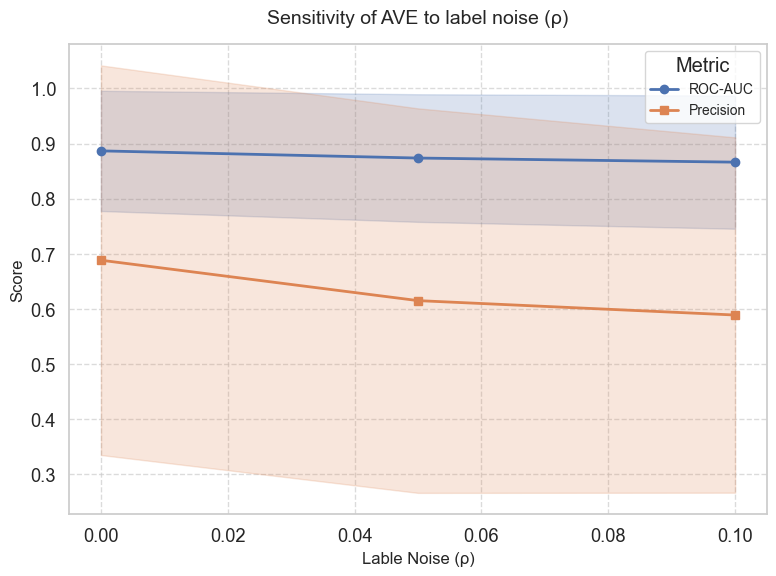

In [139]:
df = pd.read_csv("vae29_kl_weight_avg_noise_get_selected_features3.csv")
df.columns = df.columns.str.strip()
df = df[df['Run'].astype(str).str.lower() != 'average']
for col in ['Noise', 'Precision', 'ROC AUC']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['Noise', 'Precision', 'ROC AUC'])
summary = (
    df.groupby('Noise')[['Precision', 'ROC AUC']]
    .agg(['mean', 'std'])
    .reset_index()
)
summary.columns = ['Noise', 'Precision_mean', 'Precision_std', 'ROC_mean', 'ROC_std']
summary[['Precision_std', 'ROC_std']] = summary[['Precision_std', 'ROC_std']].fillna(0)

for col in ['Noise', 'Precision_mean', 'Precision_std', 'ROC_mean', 'ROC_std']:
    summary[col] = pd.to_numeric(summary[col], errors='coerce')
summary = summary.dropna().sort_values(by='Noise')

delta_precision = (summary['Precision_mean'].max() - summary['Precision_mean'].min()) * 100
delta_rocauc = (summary['ROC_mean'].max() - summary['ROC_mean'].min()) * 100
print(f"ΔPrecision = {delta_precision:.2f}%, ΔROC-AUC = {delta_rocauc:.2f}%")

x = summary['Noise'].astype(float).values
roc_mean = summary['ROC_mean'].astype(float).values
roc_std = summary['ROC_std'].astype(float).values
prec_mean = summary['Precision_mean'].astype(float).values
prec_std = summary['Precision_std'].astype(float).values

sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(8, 6))

plt.plot(x, roc_mean, marker='o', label='ROC-AUC', color='C0', linewidth=2)
plt.fill_between(x, roc_mean - roc_std, roc_mean + roc_std, alpha=0.2, color='C0')

# Precision curve
plt.plot(x, prec_mean, marker='s', label='Precision', color='C1', linewidth=2)
plt.fill_between(x, prec_mean - prec_std, prec_mean + prec_std, alpha=0.2, color='C1')

# Formatting
plt.title("Sensitivity of AVE to label noise (ρ)", fontsize=14, pad=15)
plt.xlabel("Lable Noise (ρ)", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.legend(title="Metric", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Save figure
plt.savefig("vae29_Fig_KL_Sensitivity+avg+noise.png", dpi=300)
plt.show()